In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

data_path = "data/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt"

df = pd.read_csv(data_path)
df["start_timestamp"] = df["end_timestamp"] - df["duration"]
df = df.sort_values(by="start_timestamp", ascending=True)
df["start_timestamp"] = pd.to_datetime(df["start_timestamp"], unit="s", origin=datetime.now())
df["duration"] = pd.to_timedelta(df["duration"], unit="s")
df = df.drop("app", axis=1).drop("end_timestamp", axis=1)
df.head()

,func,duration,start_timestamp
0,e3cdb48830f66eb8689cc0223514569a69812b77e6611e...,0 days 00:00:00.078000,2025-03-20 23:46:02.001490831
1,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...,0 days 00:00:57.154000,2025-03-20 23:46:02.003859997
2,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...,0 days 00:00:59.125000,2025-03-20 23:46:02.005477905
3,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...,0 days 00:00:06.236000,2025-03-20 23:46:02.016541004
4,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...,0 days 00:00:00.050000,2025-03-20 23:46:02.016824007


In [2]:
from simulator import ServerlessSimulator, Distribution

# Taken from measurements for simulator
warm_dist = Distribution([0.000017, 0.000015], [0.021617, 0.010093], [0.000007, 0.000005])
cold_dist = Distribution([1.121333, 0.629269], [0.220730, 0.045443], [0.000013, 0.000009])

In [3]:
sim = ServerlessSimulator(df, warm_dist, cold_dist,
                          default_min_num_containers=0,
                          default_warming_period=600,
                          predictor_interval=3600,
                          predictor_history_interval=100000,
                          granularity=60
                        )

logs = sim.run(df["func"].mode()[0], 100000, with_model=True)

100%|██████████| 100000/100000 [02:18<00:00, 721.01it/s]


In [4]:
sim_no = ServerlessSimulator(df, warm_dist, cold_dist,
                          default_min_num_containers=0,
                          default_warming_period=600,
                          predictor_interval=3600,
                          predictor_history_interval=100000,
                          granularity=60
                        )

logs_no = sim_no.run(df["func"].mode()[0], 100000, with_model=False)

100%|██████████| 100000/100000 [02:07<00:00, 784.97it/s]


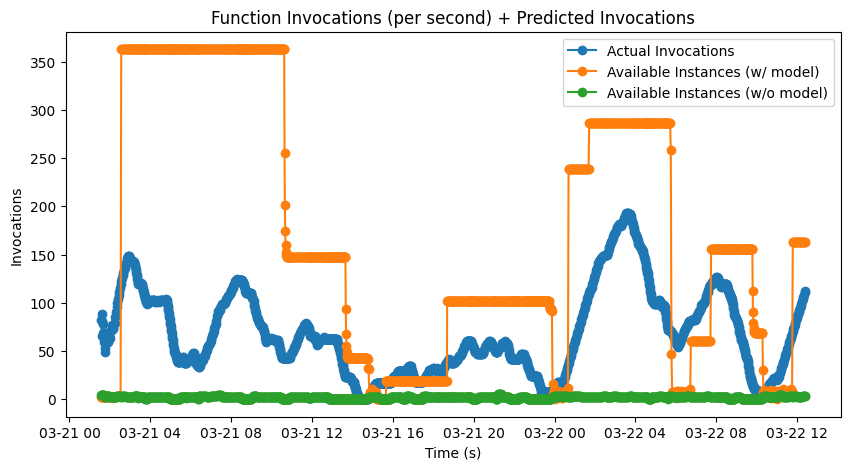

In [5]:
f = sim._functions[df["func"].mode()[0]]
f_no = sim_no._functions[df["func"].mode()[0]]

plt.figure(figsize=(10, 5))
plt.title("Function Invocations (per second) + Predicted Invocations")
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
f.history["y_s"] = f.history["y"].rolling(window=100, min_periods=1).mean() 
plt.plot(f.history['ds'], f.history['y_s'], '-o', label="Actual Invocations")

plt.plot(f.history['ds'], f.history['available_containers'], '-o', label="Available Instances (w/ model)")
plt.plot(f_no.history['ds'], f_no.history['available_containers'], '-o', label="Available Instances (w/o model)")

# for pred in f.predictions:
#     plt.plot(pred['ds'], list(map(lambda x: 0 if x < 0 else x, pred['yhat'])), '-o', color="red", label="Predicted Invocations")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


Text(0.5, 1.0, 'Function Invocations w/ model')

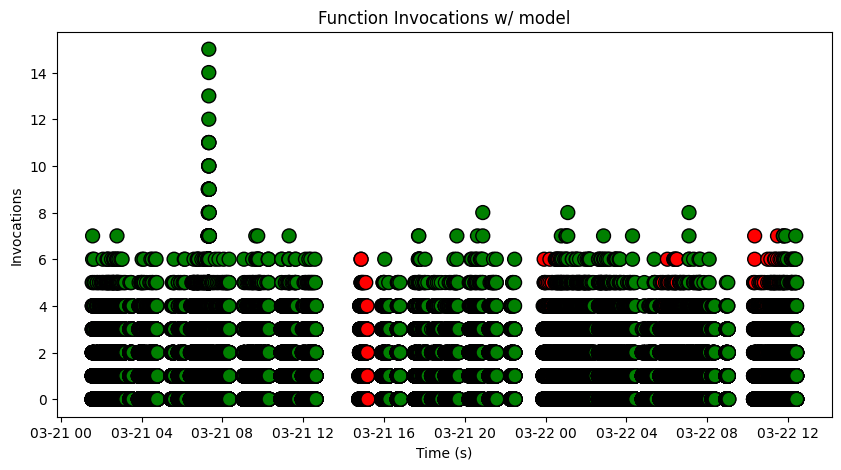

In [11]:
invoked_floor = pd.DataFrame(logs)
invoked_floor['ds'] = invoked_floor['ds'].dt.floor('s')
invoked_floor['y_jitter'] = invoked_floor.groupby('ds').cumcount()
invoked_floor['color'] = invoked_floor['is_warm_start'].map({False: 'red', True: 'green'})
plt.figure(figsize=(10, 5))
plt.scatter(invoked_floor['ds'], invoked_floor['y_jitter'], c=invoked_floor['color'], edgecolors='black', s=100)
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
plt.title('Function Invocations w/ model')

Text(0.5, 1.0, 'Function Invocations w/o model')

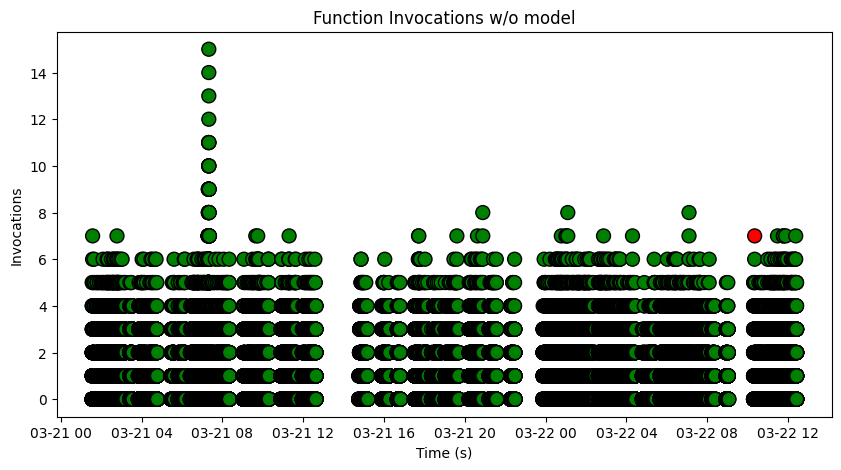

In [12]:
invoked_floor_no = pd.DataFrame(logs_no)
invoked_floor_no['ds'] = invoked_floor_no['ds'].dt.floor('s')
invoked_floor_no['y_jitter'] = invoked_floor_no.groupby('ds').cumcount()
invoked_floor_no['color'] = invoked_floor_no['is_warm_start'].map({False: 'red', True: 'green'})
plt.figure(figsize=(10, 5))
plt.scatter(invoked_floor_no['ds'], invoked_floor_no['y_jitter'], c=invoked_floor_no['color'], edgecolors='black', s=100)
plt.xlabel("Time (s)")
plt.ylabel("Invocations")
plt.title('Function Invocations w/o model')

In [13]:
print("Number of cold starts: " + str(len(list(filter(lambda x: not x, logs['is_warm_start'])))))
print("Number of warm starts: " + str(len(list(filter(lambda x: x, logs['is_warm_start'])))))

Number of cold starts: 16925
Number of warm starts: 83075


In [15]:
print("Number of cold starts: " + str(len(list(filter(lambda x: not x, logs_no['is_warm_start'])))))
print("Number of warm starts: " + str(len(list(filter(lambda x: x, logs_no['is_warm_start'])))))

Number of cold starts: 81
Number of warm starts: 99919


In [16]:
f_no.history

,ds,y,available_containers
0,2025-03-21 01:33:11,82,4
1,2025-03-21 01:35:10,81,4
2,2025-03-21 01:35:47,35,4
3,2025-03-21 01:37:45,155,4
4,2025-03-21 01:39:40,35,4
...,...,...,...
1501,2025-03-22 12:17:02,251,3
1502,2025-03-22 12:19:01,242,3
1503,2025-03-22 12:21:00,221,3
1504,2025-03-22 12:22:59,224,3
